<a href="https://colab.research.google.com/github/deek2689/CERC_AI/blob/main/GPT2_Safecity_Groping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate transformers torch -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 18.1 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


##  DATA PATHS & HYPERPARAMETERS


In [ ]:
train_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/Groping/train.csv'
test_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/Groping/test.csv'
val_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/Groping/dev.csv'
batch_size = 8
learning_rate = 1e-5
num_epochs = 10
patience = 2     # number of epochs to wait for improvement before stopping
max_length = 512

## READING DATA

In [ ]:
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

## PREPARING THE DATA

In [ ]:
## Defining Instruction text
instruction = "Classify if the following statement falls under groping related to sexual harassment. The output must be a single label: 'True' or 'False'."

def format_dataset(row):
    """
    Formats the dataset into the required structure for GPT-2 training.
    """
    formatted_text = (
        f"### Instruction:\n{instruction}\n\n"
        f"### Input:\n{row['Description']}\n\n"
        f"### Response:\n"
    )
    label = 1 if row['Category'] == 1 else 0  # Converting category to binary
    return formatted_text, label

def process_dataset(df):
    """
    Processes the data into the defined format
    """
    formatted_texts = []
    labels = []
    for _, row in df.iterrows():
        formatted_text, label = format_dataset(row)
        formatted_texts.append(formatted_text)
        labels.append(label)
    return formatted_texts, labels

# Applying the function
formatted_texts_train, labels_train = process_dataset(train_data)
formatted_texts_val, labels_val = process_dataset(val_data)
formatted_texts_test, labels_test = process_dataset(test_data)


## Tokenization

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.bos_token  # or eos_token // Since GPT2 doesnt have a pad token
tokenizer.padding_side = "left" # GPT2 being a decoder model, it uses the last token for prediction so padding on the left

def tokenize_dataset(formatted_texts, labels, max_length=512):
    tokenized = tokenizer(
        formatted_texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    labels_tensor = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels_tensor)

train_dataset = tokenize_dataset(formatted_texts_train, labels_train, max_length=max_length)
val_dataset = tokenize_dataset(formatted_texts_val, labels_val, max_length=max_length)
test_dataset = tokenize_dataset(formatted_texts_test, labels_test, max_length=max_length)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## CREATING DATALOADERS

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## SETTING UP DEVICE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device


device(type='cuda')

## MODEL AND OPTIMIZER

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## TRAINING - EVAL LOOP WITH EARLY STOPPING

In [ ]:
best_val_loss = float("inf")
epochs_unimproved = 0
train_losses = [] # To store training loss after each epoch
val_losses = [] ## Similarly for validation losses

for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  model.train()
  total_train_loss = 0

  for batch in tqdm(train_dataloader, desc = 'Training'):
    input_ids, attention_masks, batch_labels = batch
    input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
    optimizer.zero_grad()
    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_masks,
        labels = batch_labels
    )
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
  avg_train_loss = total_train_loss/len(train_dataloader)
  train_losses.append(avg_train_loss)
  print(f"Training Loss (Average): {avg_train_loss}")

  #Validation Loop
  model.eval()
  total_val_loss = 0
  val_predictions = []
  val_true_labels = []

  with torch.no_grad():
    for batch in tqdm(val_dataloader, desc = 'Validation'):
      input_ids, attention_masks, batch_labels = batch
      input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_masks,
          labels = batch_labels
      )
      loss = outputs.loss
      total_val_loss += loss.item()

      logits = outputs.logits
      probs = torch.nn.functional.softmax(logits, dim=-1)
      pred_classes = torch.argmax(probs, dim=-1)

      val_predictions.extend(pred_classes.cpu().numpy())
      val_true_labels.extend(batch_labels.cpu().numpy())

  avg_val_loss = total_val_loss / len(val_dataloader)
  val_losses.append(avg_val_loss)
  val_macro_f1 = f1_score(val_true_labels, val_predictions, average = 'macro')
  val_f1_score = f1_score(val_true_labels, val_predictions)

  print(f"  Validation loss: {avg_val_loss}")
  print(f"  Validation Macro F1 score: {val_macro_f1}")
  print(f"  Validation F1 score: {val_f1_score}")

  ## Early Stopping

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_unimproved = 0
    torch.save(model.state_dict(), "best_model.pt")
  else:
    epochs_unimproved += 1
    print(f" No improvement in validation loss for {epochs_unimproved} epoch(s).")
    if epochs_unimproved >= patience:
      print("Stopping early due to no improvement in validation loss")
      break



Epoch 1/10


Training: 100%|██████████| 901/901 [11:57<00:00,  1.26it/s]


Training Loss (Average): 0.7529429357899942


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.20it/s]


  Validation loss: 0.6168569953691575
  Validation Macro F1 score: 0.5120910045271418
  Validation F1 score: 0.18731117824773413
Epoch 2/10


Training: 100%|██████████| 901/901 [11:58<00:00,  1.25it/s]


Training Loss (Average): 0.618073261769842


Validation: 100%|██████████| 124/124 [00:20<00:00,  6.20it/s]


  Validation loss: 0.6216826756154338
  Validation Macro F1 score: 0.7139171035386631
  Validation F1 score: 0.6220238095238095
 No improvement in validation loss for 1 epoch(s).
Epoch 3/10


Training: 100%|██████████| 901/901 [11:57<00:00,  1.26it/s]


Training Loss (Average): 0.4689482413439057


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.20it/s]


  Validation loss: 0.45127323552245097
  Validation Macro F1 score: 0.786181121586598
  Validation F1 score: 0.7088607594936709
Epoch 4/10


Training: 100%|██████████| 901/901 [11:57<00:00,  1.26it/s]


Training Loss (Average): 0.38066063294565505


Validation: 100%|██████████| 124/124 [00:20<00:00,  6.20it/s]


  Validation loss: 0.3607990826450048
  Validation Macro F1 score: 0.8289579498321399
  Validation F1 score: 0.7565674255691769
Epoch 5/10


Training: 100%|██████████| 901/901 [11:57<00:00,  1.26it/s]


Training Loss (Average): 0.34262148708055473


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.21it/s]


  Validation loss: 0.333573920411929
  Validation Macro F1 score: 0.8349384098544232
  Validation F1 score: 0.7649122807017544
Epoch 6/10


Training: 100%|██████████| 901/901 [11:57<00:00,  1.26it/s]


Training Loss (Average): 0.32908721171426986


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.21it/s]


  Validation loss: 0.3548159314800174
  Validation Macro F1 score: 0.8282073840366471
  Validation F1 score: 0.7596638655462185
 No improvement in validation loss for 1 epoch(s).
Epoch 7/10


Training: 100%|██████████| 901/901 [11:58<00:00,  1.25it/s]


Training Loss (Average): 0.3071130129563458


Validation: 100%|██████████| 124/124 [00:20<00:00,  6.20it/s]


  Validation loss: 0.33317173775585907
  Validation Macro F1 score: 0.8251307408097708
  Validation F1 score: 0.754653130287648
Epoch 8/10


Training: 100%|██████████| 901/901 [11:56<00:00,  1.26it/s]


Training Loss (Average): 0.2990694674110241


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.21it/s]


  Validation loss: 0.40030072169798997
  Validation Macro F1 score: 0.8126830772393236
  Validation F1 score: 0.7460815047021944
 No improvement in validation loss for 1 epoch(s).
Epoch 9/10


Training: 100%|██████████| 901/901 [11:56<00:00,  1.26it/s]


Training Loss (Average): 0.28406936814853473


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.20it/s]

  Validation loss: 0.36581740020624093
  Validation Macro F1 score: 0.8154562743922871
  Validation F1 score: 0.7476038338658147
 No improvement in validation loss for 2 epoch(s).
Stopping early due to no improvement in validation loss


In [ ]:
# Reload the best model
model.load_state_dict(torch.load("best_model.pt"))
print("Loaded the best model for final evaluation.")

<ipython-input-13-0b7daee3da4d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Loaded the best model for final evaluation.


## Visualizing training and validation losses

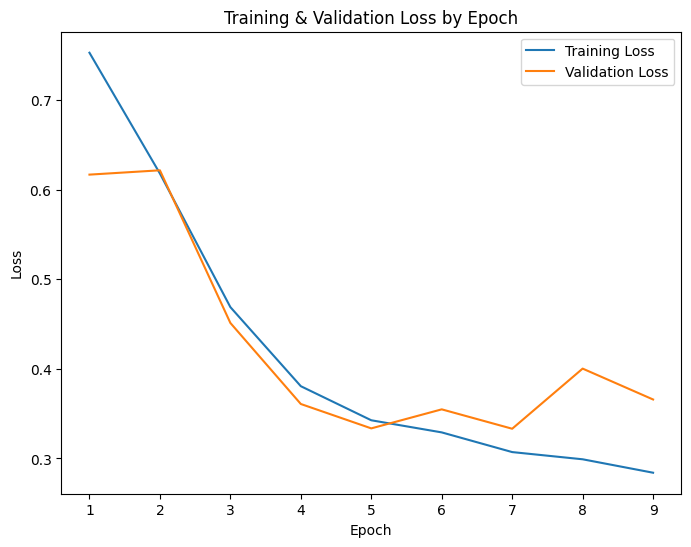

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title("Training & Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## TESTING LOOP

In [ ]:
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_masks, batch_labels = batch
        input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_masks,
            labels=batch_labels
        )

        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_classes = torch.argmax(probs, dim=1)

        test_predictions.extend(pred_classes.cpu().numpy())
        test_true_labels.extend(batch_labels.cpu().numpy())



Testing: 100%|██████████| 213/213 [00:53<00:00,  4.02it/s]


## Calculating Performance Metrics

In [ ]:
test_macro_f1 = f1_score(test_true_labels, test_predictions, average='macro')
test_F1 = f1_score(test_true_labels, test_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)

print(f"\nTest Macro F1 score: {test_macro_f1}")
print(f"Test Regular F1 score: {test_F1}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print("\nClassification Report:")
print(classification_report(test_true_labels, test_predictions))


Test Macro F1 score: 0.8414336178981454
Test Regular F1 score: 0.7790697674418605
Test Accuracy: 0.8659611992945326
Test Precision: 0.7928994082840237
Test Recall: 0.7657142857142857

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1176
           1       0.79      0.77      0.78       525

    accuracy                           0.87      1701
   macro avg       0.84      0.84      0.84      1701
weighted avg       0.86      0.87      0.87      1701

